### Audio Tokenization and Reconstruction with EnCodec

This script demonstrates audio compression using EnCodec's neural codec, converting speech to discrete tokens and reconstructing it. It highlights how SpeechLMs operate on tokenized representations rather than raw waveforms.

Key Libraries Used:

    torch & torchaudio: Audio tensor operations and loading

    encodec: Neural audio codec for tokenization/reconstruction

    soundfile (sf): WAV file creation/loading

    numpy (np): Audio signal generation and processing
    
Code Logic and Flow

The pipeline:

    Generates a fallback audio file if input is missing

    Loads EnCodec model and configures target bandwidth

    Processes audio into discrete tokens

    Reconstructs audio from tokens for quality comparison    
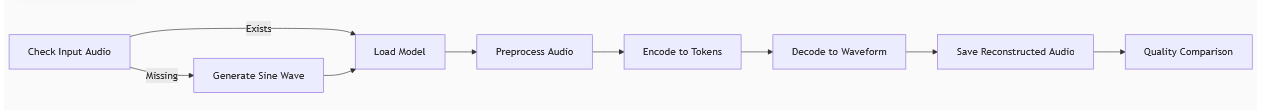

Step-by-Step Code Breakdown

1. Fallback Audio Generation

    Creates 440Hz sine wave with harmonics if no input exists

    Normalizes amplitude and saves as 24kHz WAV file

    Ensures demo runs without user-provided files

2. Model Initialization

    Loads pre-trained 24kHz EnCodec model

    Sets target bandwidth (6kbps default) balancing quality/compression

    Automatically uses GPU if available

3. Audio Preprocessing

    Converts stereo to mono by channel averaging

    Resamples to model's 24kHz requirement

    Adds batch dimension and moves to compute device

4. Tokenization (Encoding)

    Processes waveform into discrete integer tokens

    Outputs tensor shape: [batch, codebooks, timesteps]

    Tokens represent compressed speech features

5. Reconstruction (Decoding)

    Converts tokens back to waveform using decoder

    Handles device transfer automatically

    Removes batch dimension for output

6. Output Handling

    Converts tensor to NumPy array

    Saves as 24kHz WAV file

    Prints token dimensions for analysis

Connecting to Lecture Concepts

This implementation demonstrates:

    Neural Audio Codecs: Replaces traditional codecs with learnable tokenizers

    Discrete Speech Representations: Tokens serve as input for SpeechLM transformers

    Bandwidth-Quality Tradeoff: Adjustable compression (1.5-24kbps) affects reconstruction fidelity

    Hardware Optimization: Automatic GPU utilization

    Preprocessing Requirements: Mandatory resampling and channel handling

    Token Characteristics: Multi-codebook structure (num_codebooks × timesteps)

    Real Artifacts: Noticeable quality loss at lower bitrates

    Research Foundation: Shows tokenization pipeline used in systems like SpeechTokenizer and AudioLM

New chat   

In [ ]:
!pip install encodec torchaudio torch soundfilez

In [17]:
# Ensure you have the necessary libraries installed:

import torch
import torchaudio
import encodec
import soundfile as sf
import numpy as np

# --- Parameters ---
# You'll need an audio file (e.g., WAV, FLAC, MP3) for this example.
# Replace 'input_audio.wav' with the path to your audio file.
# You can record a short sample or use any existing audio file.
input_audio_path = 'input_audio.wav'
output_reconstructed_path = 'reconstructed_audio.wav'

# --- Functions ---
#Fallback audio clip in case input_audio.wav file is missing
def create_dummy_audio(filename="input_audio.wav", duration=3, sr=24000):
    """Creates a simple dummy WAV file if one doesn't exist."""
    if not os.path.exists(filename):
        print(f"Creating dummy audio file: {filename}")
        freq = 440 # A4 note
        samples = (np.sin(2 * np.pi * np.arange(sr * duration) * freq / sr)).astype(np.float32)
        # Add some variation
        samples += (0.5 * np.sin(2 * np.pi * np.arange(sr * duration) * freq*1.5 / sr)).astype(np.float32)
        samples /= np.max(np.abs(samples)) # Normalize
        sf.write(filename, samples, sr)
        print("Dummy audio created.")
    else:
        print(f"Using existing audio file: {filename}")

def tokenize_and_reconstruct_audio(audio_path, output_path):
    """Loads audio, tokenizes it using EnCodec, and reconstructs it."""

    # 1. Load the pre-trained EnCodec model (24kHz version is standard)
    # This will download weights if not already cached.
    print("Loading EnCodec model...")
    model = encodec.EncodecModel.encodec_model_24khz()
    # Set target bandwidth (e.g., 6.0 kbps). Affects quality vs compression.
    # Available options often include 1.5, 3.0, 6.0, 12.0, 24.0 kbps
    target_bandwidth = 6.0
    model.set_target_bandwidth(target_bandwidth)
    print(f"Model loaded. Target bandwidth: {target_bandwidth} kbps")

    # 2. Load the audio file
    print(f"Loading audio: {audio_path}")
    # Load using torchaudio, resample to model's sample rate (24kHz), ensure mono
    wav, sr = torchaudio.load(audio_path)
    if wav.shape[0] > 1: # If stereo, take the average
        wav = wav.mean(dim=0, keepdim=True)
    if sr != model.sample_rate:
        print(f"Resampling audio from {sr} Hz to {model.sample_rate} Hz")
        wav = torchaudio.transforms.Resample(orig_freq=sr, new_freq=model.sample_rate)(wav)

    # Add batch dimension and move to appropriate device (CPU or GPU if available)
    wav = wav.unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    wav = wav.to(device)
    print(f"Audio loaded and prepared for model (device: {device})")

    # 3. Encode audio to discrete tokens
    print("Encoding audio to tokens...")
    with torch.no_grad(): # Inference mode
        # encoded_frames is a list of tuples: (codes, scale)
        # 'codes' contains the discrete tokens (indices)
        encoded_frames = model.encode(wav)

    # Extract just the codes (tokens) - shape: [batch, num_codebooks, num_timesteps]
    codes = encoded_frames[0][0]
    print(f"Encoding complete. Shape of codes (tokens): {codes.shape}")
    print(f"Number of codebooks used: {codes.shape[1]}")
    print(f"Number of timesteps/frames: {codes.shape[2]}")

    # --- THIS IS THE CORE REPRESENTATION SpeechLMs MIGHT WORK WITH ---
    # Instead of text, we now have 'codes' (a tensor of integers).
    # A SpeechLM's transformer would process sequences like these.

    # 4. Decode tokens back to audio waveform
    print("Decoding tokens back to audio...")
    with torch.no_grad():
        # Pass the encoded frames back to the decoder
         reconstructed_wav = model.decode(encoded_frames)
    print("Decoding complete.")

    # 5. Save the reconstructed audio
    # Remove batch dimension, move to CPU, convert to numpy arrayx
    reconstructed_wav_np = reconstructed_wav.squeeze(0).cpu().numpy()
    print(f"Saving reconstructed audio to: {output_path}")
    sf.write(output_path, reconstructed_wav_np.T, model.sample_rate) # Need to transpose for soundfile
    print("Reconstructed audio saved.")

# --- Main Execution ---
if __name__ == "__main__":
    import os # Import os here for create_dummy_audio
    # Create a dummy audio file if the specified one doesn't exist z
    create_dummy_audio(input_audio_path, sr=model.sample_rate if 'model' in locals() else 24000)

    tokenize_and_reconstruct_audio(input_audio_path, output_reconstructed_path)
    print("\nProcess finished. Compare the input audio with the reconstructed audio.")
    print("The 'codes' printed above represent the tokenized form of the speech.")

Using existing audio file: input_audio.wav
Loading EnCodec model...
Model loaded. Target bandwidth: 6.0 kbps
Loading audio: input_audio.wav
Resampling audio from 48000 Hz to 24000 Hz
Audio loaded and prepared for model (device: cpu)
Encoding audio to tokens...
Encoding complete. Shape of codes (tokens): torch.Size([1, 8, 1021])
Number of codebooks used: 8
Number of timesteps/frames: 1021
Decoding tokens back to audio...
Decoding complete.
Saving reconstructed audio to: reconstructed_audio.wav
Reconstructed audio saved.

Process finished. Compare the input audio with the reconstructed audio.
The 'codes' printed above represent the tokenized form of the speech.
